In [1]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines #gym-anytrading gym

     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 245kB 34.5MB/s 
     |████████████████████████████████| 3.8MB 8.6MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 512kB 33.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=5d1ce1926dbb910b507d4f28f0c2d870c0470f5637a2a19d2fba7eac89acb12b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installati

**Importing Dataset**

In [2]:
import pandas as pd

df = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
df = df.rename(columns={'Volume USDT': 'volume'})
df = df.iloc[::-1]
df = df.drop(columns=['symbol', 'Volume BTC'])
df['date'] = pd.to_datetime(df['unix'],unit='ms')
df = df.set_index("date")
df = df.drop(columns=['unix'])
print(df.shape)
df.head(5)

(330483, 6)


,open,high,low,close,volume,tradecount
date,,,,,,
2020-09-11 20:40:00,10317.00,10317.01,10314.36,10316.00,340398.477553,342
2020-09-11 20:41:00,10316.00,10321.09,10316.00,10319.50,168497.705251,256
2020-09-11 20:42:00,10319.50,10320.31,10318.49,10319.34,125108.931436,193
2020-09-11 20:43:00,10319.34,10320.14,10318.89,10319.00,139806.963489,187
2020-09-11 20:44:00,10318.99,10319.72,10316.58,10319.47,149266.708094,284


**Implementing Env**

In [3]:
# Gym stuff
import gym

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
from enum import Enum
from matplotlib import pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from enum import Enum

class Actions(Enum):
    # Mappo sono le azioni legittime nella forma:
    # StatoAzione
    DoNothing = 0
    OpenPosition = 1
    HoldPosition = 2
    ClosePosition = 3

    # Potrei anche mappare solo le quattro azioni e poi dare il reward negativo sull'azione in base alla posizione corrente (che comunque devo tenermi salvata)


class Positions(Enum):
    # La posizione è lo stato attuale in cui si trova l'algoritmo.
    # In Free è permesso solo di fare DoNothing e OpenPosition
    # in Long è permesso di fare solo HoldPosition e ClosePosition
    Free = 0
    Long = 1

    def opposite(self):
        return Positions.Free if self == Positions.Long else Positions.Long

In [125]:
from gym import spaces
from gym.utils import seeding

class CryptoTradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, frame_bound, window_size, obs_method=0):
        assert df.ndim == 2
        assert len(frame_bound) == 2

        self._obs_method = obs_method

        self.seed()
        self.df = df
        self.frame_bound = frame_bound
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size + 1, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._balance = 10000.
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._open_position_tick = None
        self._last_trade_tick = None
        self._position = Positions.Free
        self._position_history = None
        self._total_reward = 0.
        self._total_profit = 0.
        self._balance = 10000
        self._first_rendering = None
        self.history = None
        self._action = 0

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self._balance = 10000.
        self._done = False
        self._current_tick = self._start_tick
        self._open_position_tick = 0
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Free
        self._position_history = (self.window_size * [0]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 0.  # unit
        self._first_rendering = True
        self.history = {}
        self._action = 0
        return self._get_observation()

    def step(self, action):
        '''
        Responsabilità di step():
            1. calcolare il profit attraverso la funzione di update_profit
            2. calcolare step_reward, position, open_position_tick tramite la funzione calculate_reward()
            4. aggiornare la history delle posizioni
        '''
        self._action = action
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        self._update_profit(action)
        # Attenzione! self._position viene cambiata in step_reward quindi update_profit() deve essere chiamato prima
        step_reward = self._calculate_reward(action)

        self._position_history.append(self._position)

        observation = self._get_observation()
        
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            balance = self._balance,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def _calculate_reward(self, action):
        '''
        Responsabilità di calculate_reward:
            1. Calcolare il reward
            2. Aggiornare self._total_reward
            3. Aggiornare self._position
            4. Aggiornare self._open_position_tick

        Logica di reward per azioni LEGITTIME:
                    - ClosePosition (da Long a Free) = profit di quella posizione
                    - OpenPosition (da Free a Long) = reward di incentivo per aprire posizione
                    - HoldPosition (da Long a Long) = profit che verrebbe fatta da quando si è aperta la posizione se si vendesse in quel momento
                    - DoNothing (da Free a Free) = 0 di reward, non punisco e lo incentivo in nessun modo su questa posizione

        Logica di reward per azioni ILLEGITTIME (tutte le coppie non listate sopra):
                    - Do un piccolo reward negativo di disincentivo per tutte le azioni illeggitime
                        ma non faccio cambiare il sistema

        Funzione di transizione: (Stato, Azione) -> Stato

        :param action:
        :return:
        '''
        step_reward = -1
        new_position = self._position

        # (Free, DoNothing) -> Free
        if action == Actions.DoNothing.value and self._position == Positions.Free:
            step_reward = 0

        # (Free, OpenPosition) -> Long
        elif action == Actions.OpenPosition.value and self._position == Positions.Free:
            new_position = self._position.opposite()
            self._open_position_tick = self._current_tick
            # con 0.95 fa a malapena un trade ogni 50/60 step, con step_reward 1 ne fa uno quasi ogni paio di step...
            step_reward = 0.95

        # (Long, HoldPosition) -> Long
        elif action == Actions.HoldPosition.value and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            price_diff = current_price - open_position_price
            step_reward += price_diff

        # (Long, ClosePosition) -> Free
        elif action == Actions.ClosePosition.value and self._position == Positions.Long:
            new_position = self._position.opposite()
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            price_diff = current_price - open_position_price
            step_reward += price_diff

        self._total_reward += step_reward
        self._position = new_position
        return step_reward

    def _update_profit(self, action):
        '''
        Responsabilità di update_profit():
            1. Aggiornare self._total_profit con il profit reale
            2. Aggiornare self._balance con il balance dopo la chiusura della transazione
        :param action:
        :return:
        '''

        temp_balance = self._balance
        if action == Actions.ClosePosition.value and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            self._balance = (self._balance / open_position_price) * current_price
            #se total profit inizializzato a 0
            self._total_profit += self._balance - temp_balance

    def _get_observation(self):
      action = self._action
      if self._obs_method == 0:
        return self._get_observation_0()
      elif self._obs_method == 1:
        return self._get_observation_1(action)
      else:
        print("NON TORNA OSSERVAZIONI")

    def _get_observation_0(self):
        obs = self.signal_features[(self._current_tick - self.window_size):self._current_tick]
        obs = np.vstack([obs, [self._position.value, -1]])
        return obs
    
    # Gli appendo sia la attuale posizione che l'azione appena svolta
    def _get_observation_1(self, action):
        obs = self.signal_features[(self._current_tick - self.window_size):self._current_tick]
        obs = np.vstack([obs, [self._position.value, action]])
        return obs


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def render(self, mode='human'):
        def _plot_position(position, tick):
            color = None
            if position == Positions.Free:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit + ' ~ ' +
            "Total Balance: %.6f" % self._balance
        )

        plt.pause(0.01)

    # def render_all(self, mode='human'):
    #     window_ticks = np.arange(len(self._position_history))
    #     plt.plot(self.prices)
    #
    #     short_ticks = []
    #     long_ticks = []
    #     for i, tick in enumerate(window_ticks):
    #         if self._position_history[i] == Positions.Free:
    #             short_ticks.append(tick)
    #         elif self._position_history[i] == Positions.Long:
    #             long_ticks.append(tick)
    #
    #     plt.plot(short_ticks, self.prices[short_ticks], 'ro')
    #     plt.plot(long_ticks, self.prices[long_ticks], 'go')
    #
    #     plt.suptitle(
    #         "Total Reward: %.6f" % self._total_reward + ' ~ ' +
    #         "Total Profit: %.6f" % self._total_profit + ' ~ ' +
    #         "Balance: %.6f" % self._balance
    #     )

    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if i != 0:
                current_tick = self._position_history[i]
                prev_tick = self._position_history[i - 1]
                if current_tick != prev_tick:
                    if current_tick == Positions.Free:
                        short_ticks.append(tick)
                    elif current_tick == Positions.Long:
                        long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit + ' ~ ' +
            "Balance: %.6f" % self._balance
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        prices = self.df['close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features

    #############################################################################################################

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

**Register and Init Env**

In [126]:
id_str = 'cryptostocks-v1'

del  gym.envs.registry.env_specs['cryptostocks-v1']

from gym.envs.registration import register
register(
    id=id_str,
    entry_point=CryptoTradingEnv,
)

**Declare and Train Agent**

In [127]:
#env_maker = lambda: gym.make(id_str, df=df, frame_bound=(22,10000), window_size=22)
#env = DummyVecEnv([env_maker])

In [128]:
#model = A2C('MlpLstmPolicy', env, verbose=1) 
#model.learn(total_timesteps=150000)

In [145]:
env_makers = []
envs = []
models = []
i = 0
while i < 2:
  print(i)
  env_makers.append(lambda: gym.make(id_str, df=df, frame_bound=(22,10000), window_size=22, obs_method=i))
  envs.append(DummyVecEnv([env_makers[i]]))
  models.append(A2C('MlpLstmPolicy', envs[i], verbose=1)) 
  models[i].learn(total_timesteps=75000)
  i += 1


0
---------------------------------
| explained_variance | -0.0165  |
| fps                | 17       |
| nupdates           | 1        |
| policy_entropy     | 1.38     |
| total_timesteps    | 5        |
| value_loss         | 1.52     |
---------------------------------
----------------------------------
| explained_variance | -3.59e-05 |
| fps                | 308       |
| nupdates           | 100       |
| policy_entropy     | 1.38      |
| total_timesteps    | 500       |
| value_loss         | 2.05      |
----------------------------------
----------------------------------
| explained_variance | -0.000511 |
| fps                | 335       |
| nupdates           | 200       |
| policy_entropy     | 1.38      |
| total_timesteps    | 1000      |
| value_loss         | 5.83      |
----------------------------------
----------------------------------
| explained_variance | -0.000871 |
| fps                | 346       |
| nupdates           | 300       |
| policy_entropy     | 1.3

In [130]:
# import random

# #330483
# # frame_bound=(22, 401)
# infos = []
# for j in range(1, 10):
#   env = gym.make(id_str, df=df, frame_bound=(10001,10379), window_size=22)
#   obs = env.reset()
#   # done = False in due casi:
#   #                     - quando viene fatta una azione invalida (ma a quanto pare ha imparato a non farne)
#   #                     - quando finisce tutti i timesteps passati in frame bound. Siccome in step immediatamente viene fatto il +1 bisogna che impostare
#   #                         range(frame_bound.min, frame_bound.max -1)
#   for i in range(10001, 10378): 
#       obs = obs[np.newaxis, ...]
#       action, _states = model.predict(obs)
#       obs, rewards, done, info = env.step(action)
#       if done:
#           print("info", info)
#           infos.append(info)
#           plt.figure(figsize=(15,6))
#           plt.cla()
#           env.render_all()
#           plt.show()
#           break
# for i in infos:
#   print(i)

info {'total_reward': -139.29999999999626, 'total_profit': 47.19436102451073, 'balance': 10047.19436102451, 'position': 1}


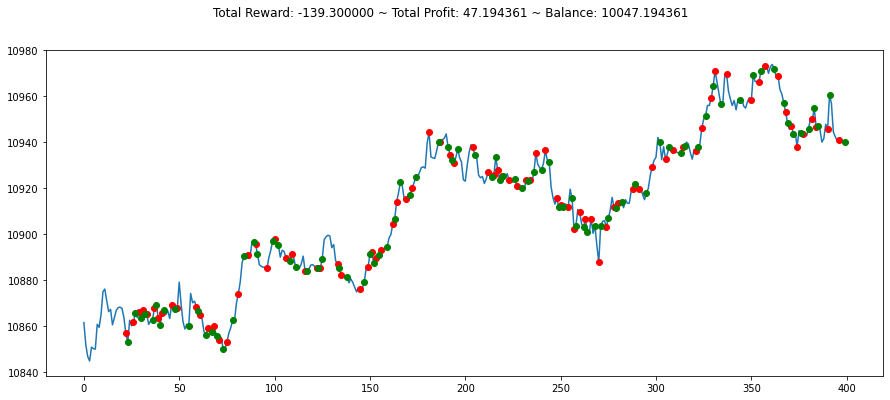

info {'total_reward': -57.28999999999937, 'total_profit': 115.02852572326447, 'balance': 10115.028525723264, 'position': 1}


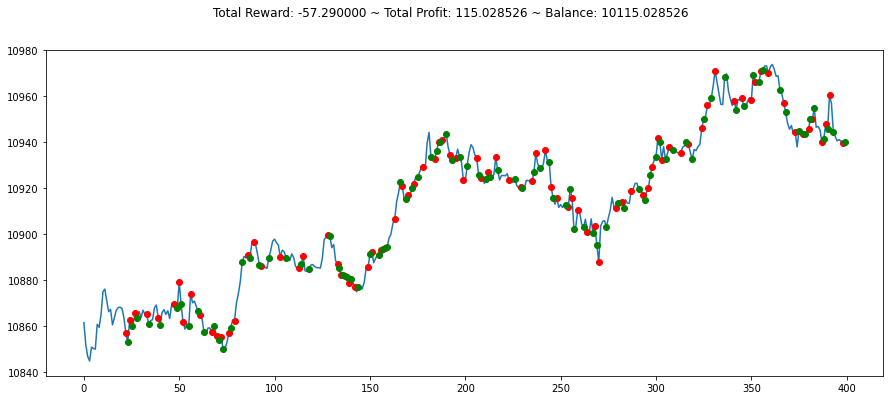

info {'total_reward': -65.28000000001073, 'total_profit': 68.77884451495993, 'balance': 10068.77884451496, 'position': 1}


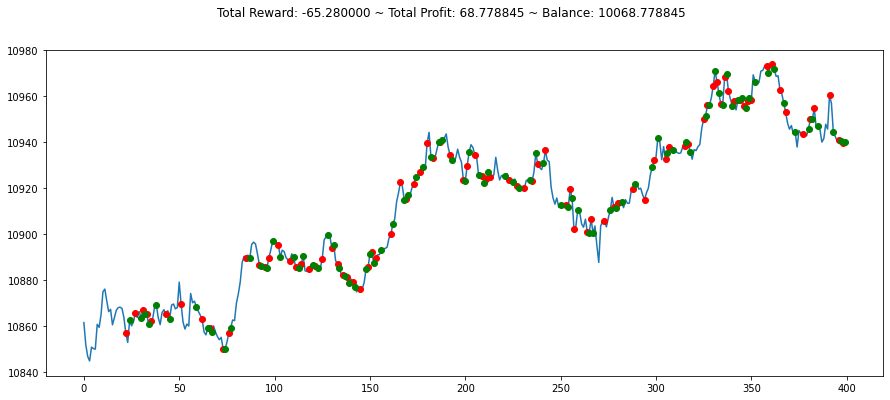

info {'total_reward': -162.0700000000033, 'total_profit': 43.802795952373344, 'balance': 10043.802795952373, 'position': 0}


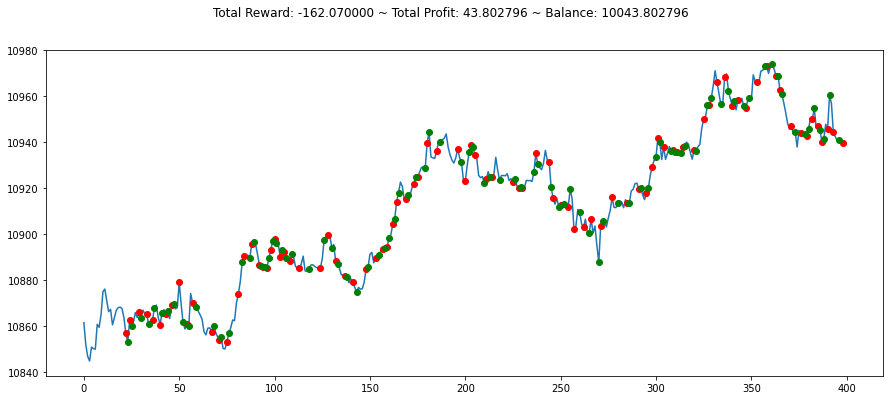

info {'total_reward': -37.409999999987875, 'total_profit': 135.94572629729737, 'balance': 10135.945726297297, 'position': 1}


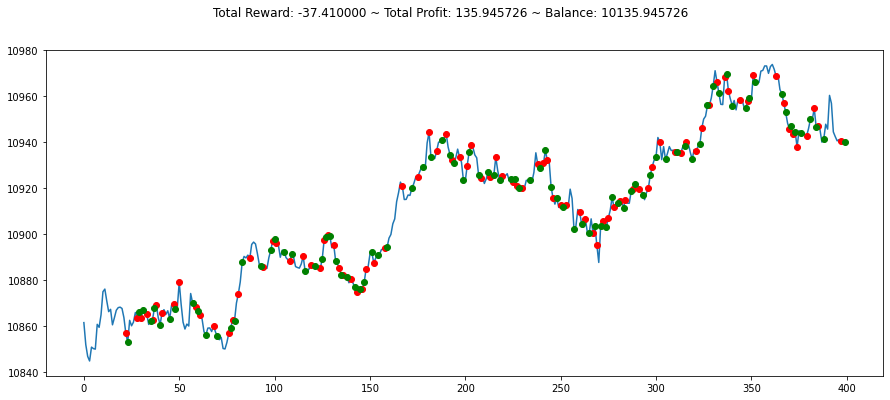

info {'total_reward': -115.56999999999015, 'total_profit': 81.63773459437107, 'balance': 10081.637734594371, 'position': 0}


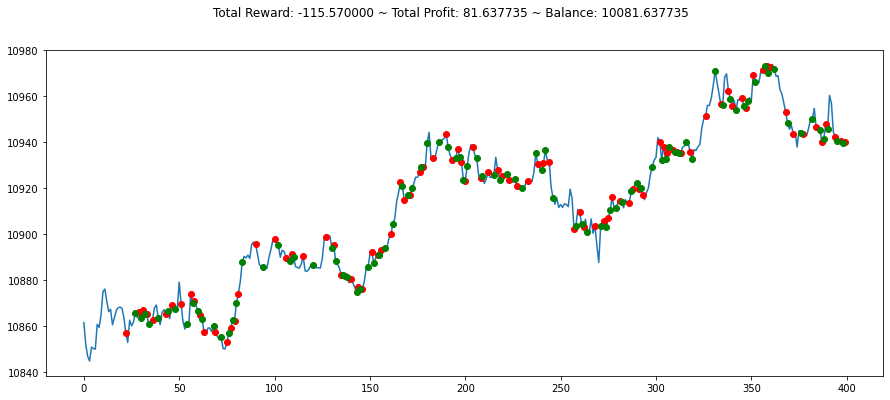

info {'total_reward': -66.97000000000362, 'total_profit': 111.60692445160748, 'balance': 10111.606924451607, 'position': 0}


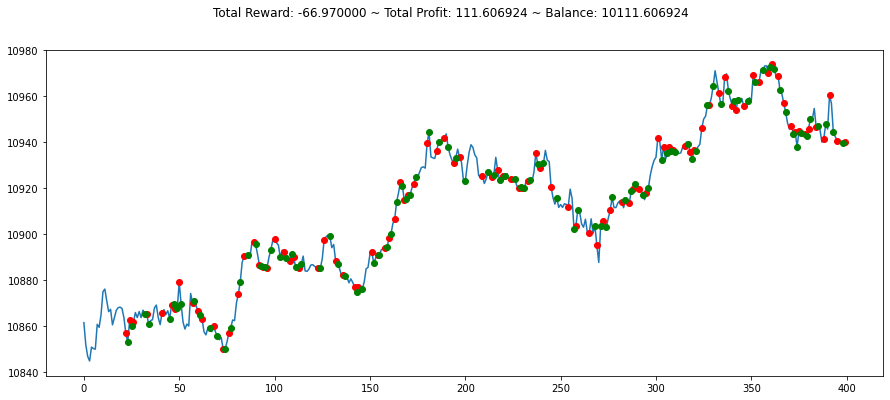

info {'total_reward': -109.26000000001719, 'total_profit': 67.80691368940279, 'balance': 10067.806913689403, 'position': 0}


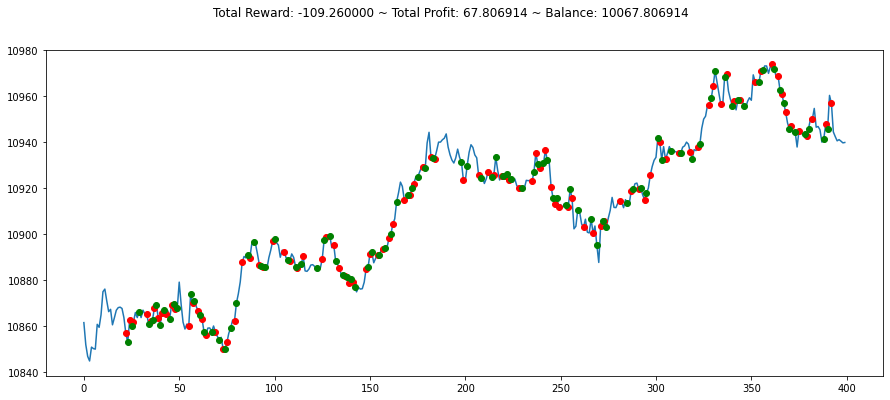

info {'total_reward': -144.19000000001824, 'total_profit': 54.54375348523536, 'balance': 10054.543753485235, 'position': 0}


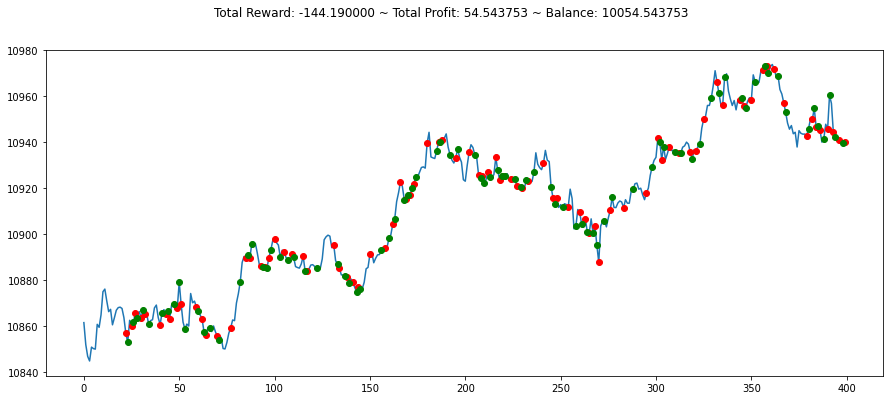

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -168.53000000000503, 'total_profit': 0.0, 'balance': 10000.0, 'position': 1}


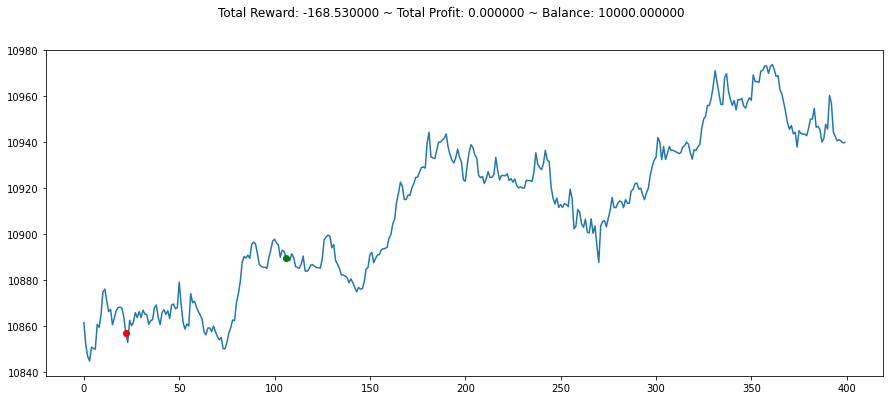

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -164.00999999999988, 'total_profit': 61.24736475154168, 'balance': 10061.247364751542, 'position': 1}


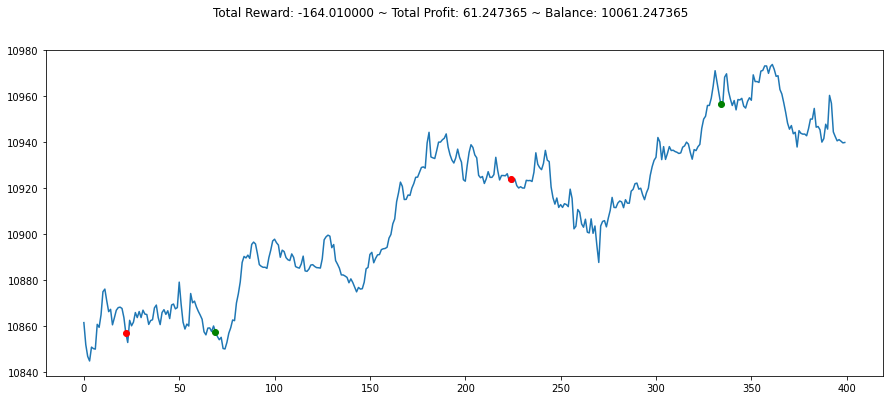

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -123.45000000000037, 'total_profit': 56.972063174318464, 'balance': 10056.972063174318, 'position': 1}


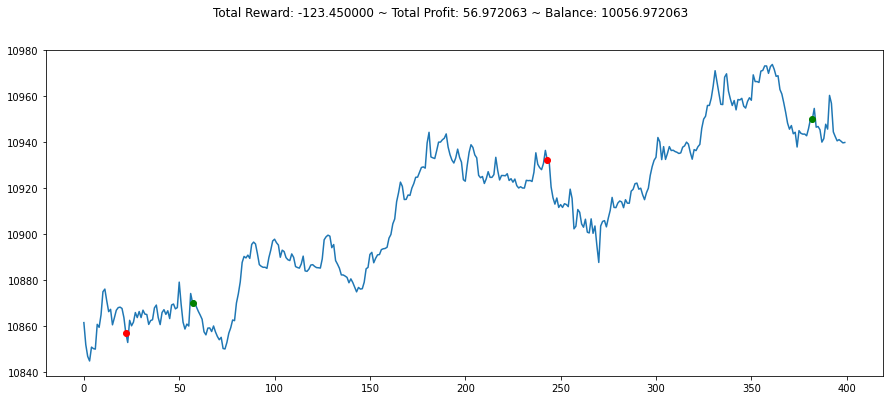

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -13.460000000000576, 'total_profit': 16.611676851289303, 'balance': 10016.61167685129, 'position': 0}


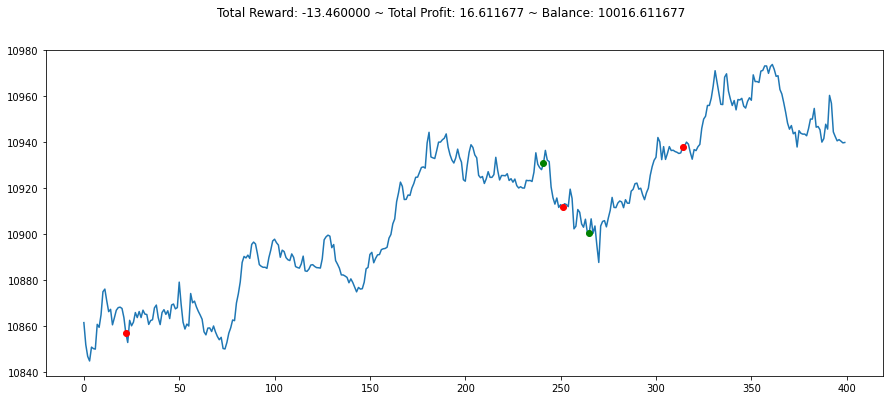

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -137.89999999999998, 'total_profit': 86.76555262887632, 'balance': 10086.765552628876, 'position': 0}


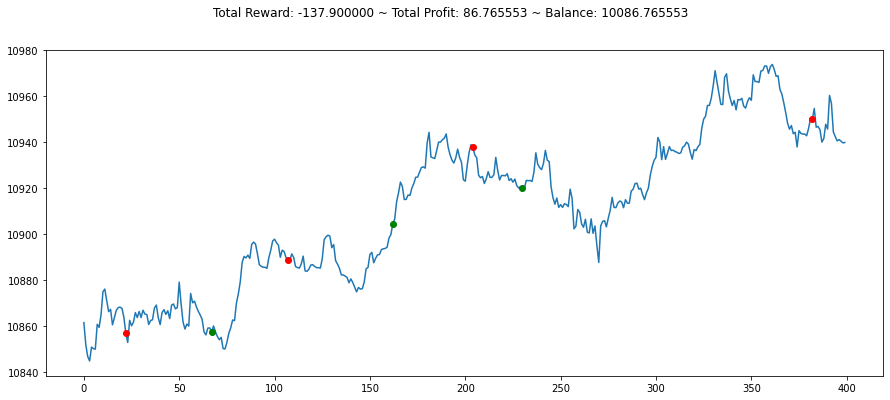

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -48.86999999999935, 'total_profit': 76.37015126497681, 'balance': 10076.370151264977, 'position': 0}


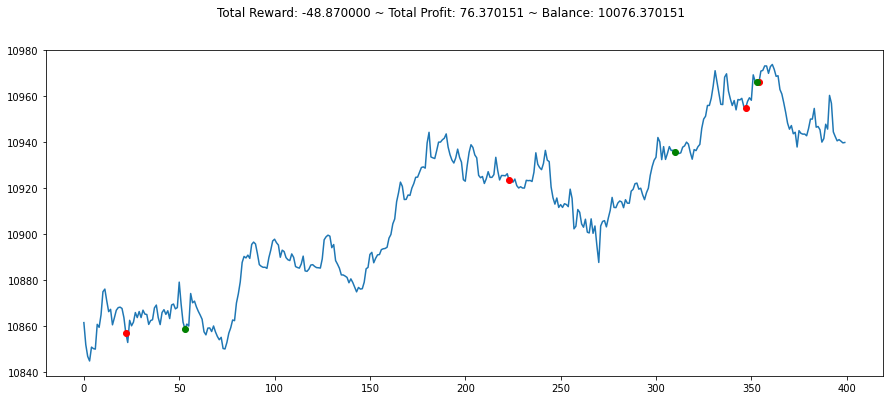

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -173.8499999999982, 'total_profit': 56.51403181619389, 'balance': 10056.514031816194, 'position': 1}


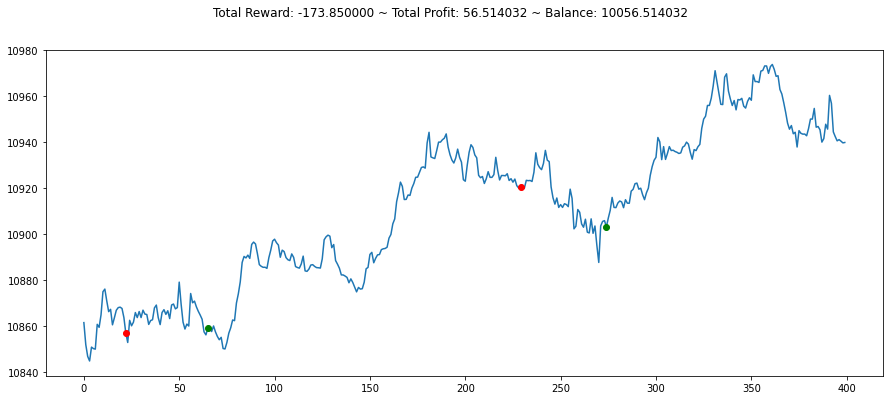

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -68.09000000000052, 'total_profit': 37.32913393230956, 'balance': 10037.32913393231, 'position': 1}


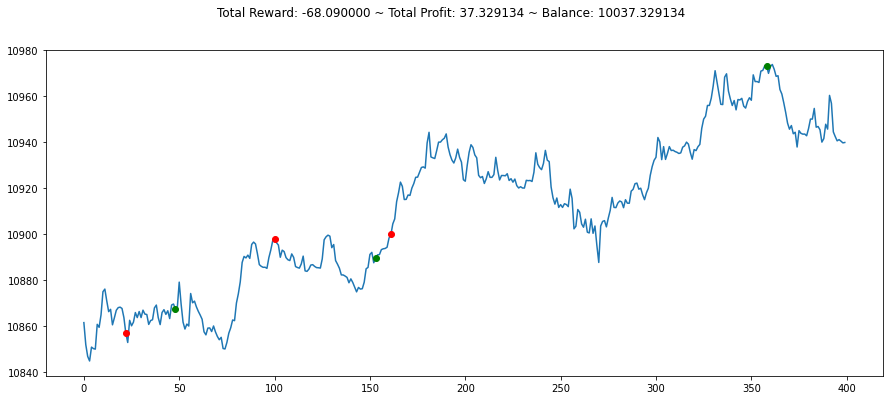

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


info {'total_reward': -254.48000000000212, 'total_profit': 0.0, 'balance': 10000.0, 'position': 1}


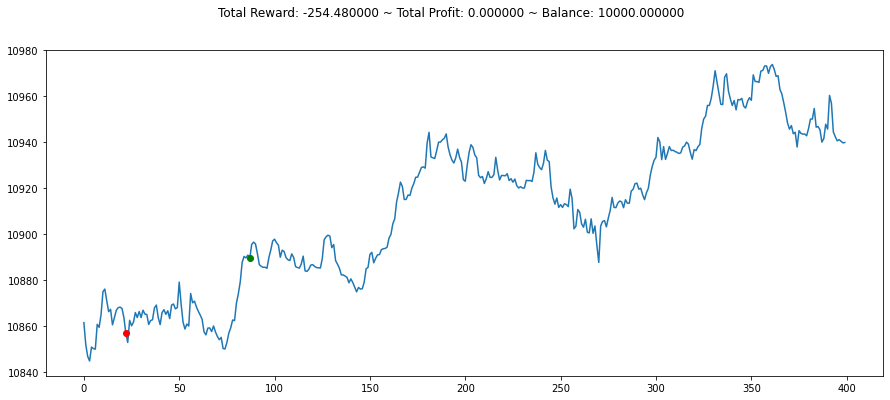

##########################
{'total_reward': -139.29999999999626, 'total_profit': 47.19436102451073, 'balance': 10047.19436102451, 'position': 1}
{'total_reward': -57.28999999999937, 'total_profit': 115.02852572326447, 'balance': 10115.028525723264, 'position': 1}
{'total_reward': -65.28000000001073, 'total_profit': 68.77884451495993, 'balance': 10068.77884451496, 'position': 1}
{'total_reward': -162.0700000000033, 'total_profit': 43.802795952373344, 'balance': 10043.802795952373, 'position': 0}
{'total_reward': -37.409999999987875, 'total_profit': 135.94572629729737, 'balance': 10135.945726297297, 'position': 1}
{'total_reward': -115.56999999999015, 'total_profit': 81.63773459437107, 'balance': 10081.637734594371, 'position': 0}
{'total_reward': -66.97000000000362, 'total_profit': 111.60692445160748, 'balance': 10111.606924451607, 'position': 0}
{'total_reward': -109.26000000001719, 'total_profit': 67.80691368940279, 'balance': 10067.806913689403, 'position': 0}
{'total_reward': -144.1

In [146]:
import random

results = []
for m in range(0, 2):
  infos = []
  for j in range(1, 10):
    env = gym.make(id_str, df=df, frame_bound=(10001,10379), window_size=22, obs_method=m)
    obs = env.reset()
    for i in range(10001, 10378):
      obs = obs[np.newaxis, ...]
      action, _states = models[m].predict(obs)
      obs, reward, done, info = env.step(action)
      if done:
        print("info", info)
        infos.append(info)
        plt.figure(figsize=(15, 6))
        plt.cla()
        env.render_all()
        plt.show()
        #break
  results.append(infos)
  #for info in infos:
    #print(info)
for result in results:
  print("##########################")
  for info in result:
    print(info)

In [ ]:
holding_rewards = []


holding_reward = (current_price - open_position_price ) / open_position_price
holding_rewards.append(holding_reward)
step_reward = np.mean(holding_reward)

In [9]:
import numpy as np

np.empty
zero = np.zeros(0)
zero = np.append(zero, 5)
zero

array([5.])